In [1]:
from pymongo import MongoClient
from pprint import pprint
con = MongoClient("localhost",27017)

db = con.newdb


In [7]:
%cd C:\encore_migo\py_workspace\data


C:\encore_migo\py_workspace\data


In [8]:
!mongoimport --help

Usage:
  mongoimport <options> <connection-string> <file> 

Import CSV, TSV or JSON data into MongoDB. If no file is provided, mongoimport reads from stdin.

Connection strings must begin with mongodb:// or mongodb+srv://.

See http://docs.mongodb.com/database-tools/mongoimport/ for more information.

general options:
      /help                                       print usage
      /version                                    print the tool version and
                                                  exit
      /config:                                    path to a configuration file

verbosity options:
  /v, /verbose:<level>                            more detailed log output
                                                  (include multiple times for
                                                  more verbosity, e.g. -vvvvv,
                                                  or specify a numeric value,
                                                  e.g. --verbose=N)
      /qu

In [6]:
#to get fields names
import pandas as pd

df = pd.read_csv("../../../encore_migo/py_workspace/data/googleplaystore.csv")
df.columns

Index(['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type',
       'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver',
       'Android Ver'],
      dtype='object')

In [17]:
!mongoimport -d newdb -c gstore --type csv --fields App,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Genres,Last_Updated,Current_Ver,Android_Ver --file C:\encore_migo\py_workspace\data\googleplaystore.csv

2021-09-15T19:35:53.571+0900	connected to: mongodb://localhost/
2021-09-15T19:35:53.815+0900	10842 document(s) imported successfully. 0 document(s) failed to import.


In [2]:
#delete header
#db.gstore.delete_one({})

for i in db.gstore.find().limit(3):
    pprint(i)
    

{'Android_Ver': '4.0.3 and up',
 'App': 'Coloring book moana',
 'Category': 'ART_AND_DESIGN',
 'Content_Rating': 'Everyone',
 'Current_Ver': '2.0.0',
 'Genres': 'Art & Design;Pretend Play',
 'Installs': '500,000+',
 'Last_Updated': 'January 15, 2018',
 'Price': 0,
 'Rating': 3.9,
 'Reviews': 967,
 'Size': '14M',
 'Type': 'Free',
 '_id': ObjectId('6141cc89e15b2cf95a19b7fb')}
{'Android_Ver': '4.2 and up',
 'App': 'Sketch - Draw & Paint',
 'Category': 'ART_AND_DESIGN',
 'Content_Rating': 'Teen',
 'Current_Ver': 'Varies with device',
 'Genres': 'Art & Design',
 'Installs': '50,000,000+',
 'Last_Updated': 'June 8, 2018',
 'Price': 0,
 'Rating': 4.5,
 'Reviews': 215644,
 'Size': '25M',
 'Type': 'Free',
 '_id': ObjectId('6141cc89e15b2cf95a19b7fc')}
{'Android_Ver': '4.0.3 and up',
 'App': 'Smoke Effect Photo Maker - Smoke Editor',
 'Category': 'ART_AND_DESIGN',
 'Content_Rating': 'Everyone',
 'Current_Ver': 1.1,
 'Genres': 'Art & Design',
 'Installs': '50,000+',
 'Last_Updated': 'April 26, 201

In [72]:
#correlationship between price & rating
#1
import matplotlib.pyplot as plt
import re


lst = []
for i in db.gstore.find({},{'_id':1,'Price':1,"Rating":1}):
    if type(i['Price'])==int:
        i["Price"] = float(i['Price'])
        lst.append(i)
    if type(i['Price'])==str:
        try:
            i["Price"] = float(i['Price'][1:])
            lst.append(i)
        except:
            pass

#data locality 

In [75]:
df = pd.DataFrame(lst).dropna()

(0.0, 100.0)

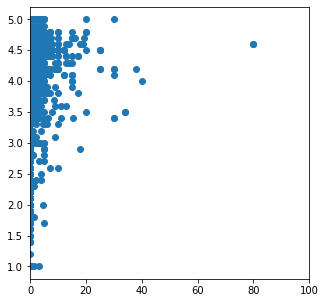

In [81]:
plt.figure(figsize=(5,5))
plt.scatter("Price","Rating",data=df)
plt.xlim(0,100)


In [123]:
#Representing the same result through query on Mongo 
lst2=[]
for i in db.gstore.aggregate([{"$match":{"$or" :[{"Price":{"$regex":"([0-9])"}},{"Price":{"$type":16}}]}},
                             {"$project":{'_id':1,'Price':{"$cond":{"if":{"$isNumber":"$Price"},
                                                                    "then":"$Price", 
                                                                    "else":{"$convert":{"input":{"$substr":["$Price",1,10]},
                                                                                        "to":"double"}}}},"Rating":1}}]):
    lst2.append(i)

In [124]:
pd.DataFrame(lst2)

,_id,Rating,Price
0,6141cc89e15b2cf95a19b7fb,3.9,0.0
1,6141cc89e15b2cf95a19b7fc,4.5,0.0
2,6141cc89e15b2cf95a19b7fd,3.8,0.0
3,6141cc89e15b2cf95a19b7fe,4.1,0.0
4,6141cc89e15b2cf95a19b7ff,4.1,0.0
...,...,...,...
10835,6141cc89e15b2cf95a19e24f,4.8,0.0
10836,6141cc89e15b2cf95a19e250,4.5,0.0
10837,6141cc89e15b2cf95a19e251,4.0,0.0
10838,6141cc89e15b2cf95a19e252,4.5,0.0


In [168]:
# 'Installs': '500,000+'

for i in db.gstore.aggregate([{"$project":{
                                "App":1,
                                "_id":0,
                                "Installs":{"$convert":{"input":{"$replaceAll":{"input":{"$substr":["$Installs",0,{"$subtract":[{"$strLenCP":"$Installs"},1]}]}
                                                           ,"find":",",
                                                           "replacement":""}},
                                                       "to":"double"}}}}]):
    print(i)

{'App': 'Coloring book moana', 'Installs': 500000.0}
{'App': 'Sketch - Draw & Paint', 'Installs': 50000000.0}
{'App': 'Smoke Effect Photo Maker - Smoke Editor', 'Installs': 50000.0}
{'App': 'Infinite Painter', 'Installs': 1000000.0}
{'App': 'Photo Editor & Candy Camera & Grid & ScrapBook', 'Installs': 10000.0}
{'App': 'Pixel Draw - Number Art Coloring Book', 'Installs': 100000.0}
{'App': 'Paper flowers instructions', 'Installs': 50000.0}
{'App': 'Garden Coloring Book', 'Installs': 1000000.0}
{'App': 'Kids Paint Free - Drawing Fun', 'Installs': 10000.0}
{'App': 'Text on Photo - Fonteee', 'Installs': 1000000.0}
{'App': 'Name Art Photo Editor - Focus n Filters', 'Installs': 1000000.0}
{'App': 'Tattoo Name On My Photo Editor', 'Installs': 10000000.0}
{'App': 'Mandala Coloring Book', 'Installs': 100000.0}
{'App': '3D Color Pixel by Number - Sandbox Art Coloring', 'Installs': 100000.0}
{'App': 'Learn To Draw Kawaii Characters', 'Installs': 5000.0}
{'App': 'Photo Designer - Write your name wi

OperationFailure: $strLenCP requires a string argument, found: int, full error: {'ok': 0.0, 'errmsg': '$strLenCP requires a string argument, found: int', 'code': 34471, 'codeName': 'Location34471'}